In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("talk")
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from collections import Counter
import xgboost as xgb
from itertools import chain

In [2]:
DATA_FOLDER = '../readonly/final_project_data/'

transactions = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

In [3]:
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
#we have shop_id and item_id

In [4]:
display(transactions.head())
display(items.head())
display(item_categories.head())
display(shops.head())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000,1.000
1,03.01.2013,0,25,2552,899.000,1.000
2,05.01.2013,0,25,2552,899.000,-1.000
3,06.01.2013,0,25,2554,1709.050,1.000
4,15.01.2013,0,25,2555,1099.000,1.000


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


First, let's focus only on transactions. and item category. THe other dfs just have product info. But the names might be useful later.

In [7]:
data = (
    transactions
    #.merge(items[["item_id", "item_category_id"]])

    .assign(date_c=lambda x: pd.to_datetime(x.date, format="%d.%m.%Y"))
    .assign(month=lambda x: x.date_c.dt.month, year=lambda x: x.date_c.dt.year,
            day=lambda x: x.date_c.dt.day)
    .query("item_price>0")
    .drop(columns=["date","day","year"])
#    .query("month>=9")

)

In [10]:
data.query("item_id==5268")

,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_c,month


In [6]:
samep=(data
 .groupby(["shop_id","item_id"])
 .item_price.agg(["max","min","mean"])
 .rename(columns={"max":"max_c","min":"min_c"})
 .assign(sameprice=lambda x: x.eval("max_c==min_c"))
 .reset_index()
 .drop(columns=["max_c","min_c"])
 .rename(columns={0:"sameprice","mean":"item_price"})
 )
samep

,shop_id,item_id,item_price,sameprice
0,2,31,399.000,True
1,2,32,149.000,True
2,2,33,199.000,True
3,2,97,149.000,True
4,2,464,299.000,True
5,2,472,399.000,True
6,2,482,3300.000,True
7,2,485,300.000,True
8,2,486,300.000,True
9,2,491,600.000,True


In [7]:
samep_ready=samep.query("sameprice==True").drop(columns="sameprice")

In [8]:
data_ready=(data.merge(samep.query("sameprice==False")
            .drop(columns="item_price"),how="left")
 .query("sameprice==False")
 .drop("sameprice",axis=1)
        
)

In [9]:
def last_item(x):
    return(x[x.date_block_num==x.date_block_num.max()].item_price.mean())
price_shop_item=data_ready.groupby(["shop_id","item_id"]).apply(last_item)
price_shop_item=price_shop_item.to_frame().reset_index().rename(columns={0:"item_price"})

In [10]:
final_prices=pd.concat([price_shop_item,samep_ready])

In [11]:
data_bymonth=data.drop(columns=["item_price","date_c","month"])

In [12]:
#We can get month from date block num
data[["month","date_block_num"]].assign(month2=lambda x: x.eval("date_block_num%12+1"))

,month,date_block_num,month2
837241,9,8,9
837242,9,8,9
837243,9,8,9
837244,9,8,9
837245,9,8,9
837246,9,8,9
837247,9,8,9
837248,9,8,9
837249,9,8,9
837250,9,8,9


In [13]:
data_bymonth=data_bymonth.groupby(["shop_id","item_id","date_block_num"]).sum().reset_index()

In [14]:
data_bymonth

,shop_id,item_id,date_block_num,item_cnt_day
0,2,31,33,1.000
1,2,32,20,2.000
2,2,32,21,2.000
3,2,32,23,2.000
4,2,33,10,2.000
5,2,33,11,1.000
6,2,33,20,1.000
7,2,33,32,1.000
8,2,97,10,1.000
9,2,464,9,2.000


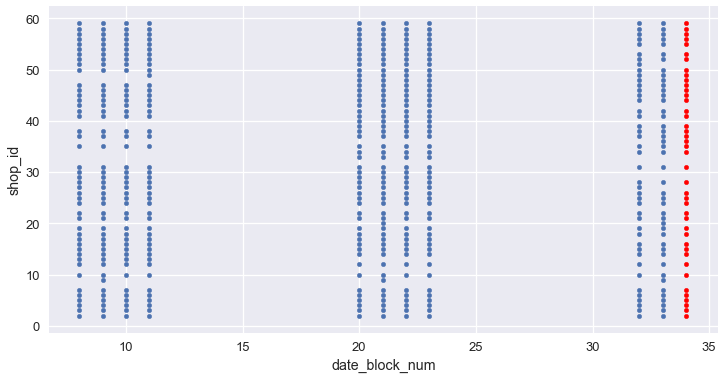

In [15]:
data_bymonth.groupby(["date_block_num","shop_id"]).item_id.pipe(lambda x: (x.count()>0)).reset_index().plot.scatter("date_block_num","shop_id")
(test.assign(date_block_num=60).drop(columns="ID").groupby("shop_id")
 .item_id.pipe(lambda x: (x.count()>0)).reset_index()
 .assign(date_block_num=34)
 .plot.scatter("date_block_num","shop_id",c="red",ax=plt.gca())
)

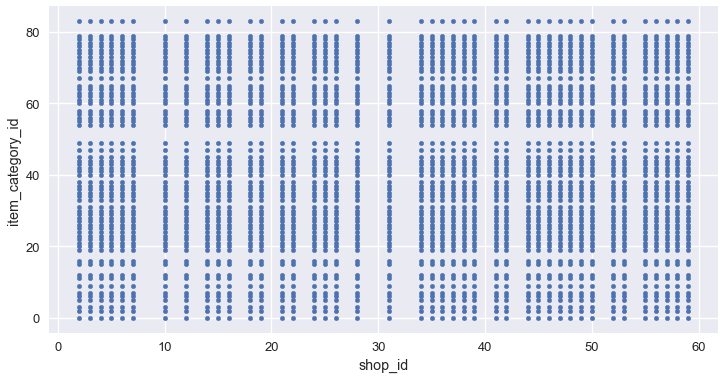

In [16]:
test.merge(items,how="left").groupby(["shop_id","item_category_id"]).count().reset_index().plot.scatter("shop_id","item_category_id")

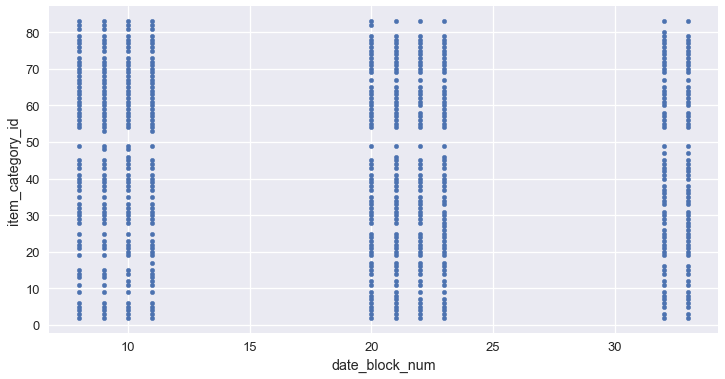

In [17]:
(data_bymonth.merge(items,how="left")[["item_category_id","date_block_num","item_cnt_day"]]
 .groupby(["item_category_id","date_block_num"]).pipe(lambda x: (x.count()>0)).reset_index()
 .plot.scatter("date_block_num","item_category_id")

)

In [18]:
#Let's find items to get rid of
(data_bymonth.merge(items,how="left")[["item_id","date_block_num","item_cnt_day"]]
 .groupby(["item_id","date_block_num"]).pipe(lambda x: (x.count()>0)).reset_index()
 .groupby("date_block_num")
 .item_id.apply(lambda x: len(x.unique()))

)

date_block_num
8     7876
9     8039
10    8089
11    8474
20    6071
21    6334
22    6322
23    6605
32    5085
33    5413
Name: item_id, dtype: int64

In [19]:
#Let's tr
#test.item_id.pipe(lambda x: len(x.unique()))

### Text processing

In [20]:
shops_text=shops.copy()
regex=r'!|,|[0-9]|"|\?|²|\.|\(|\)|-'
def one(x):
    return [i for i in x if len(i)>=2]
def expander(x):
    for i in x.shop_name:
        x[i]=1

    return x
t=pd.Series((shops_text.shop_name
 .str.lower()
 .str.replace(regex,"")
 .str.split()
 .apply(one)
 
    
))
t=(t
.to_frame()
 .apply(expander,axis=1)
 .fillna(0)
 .drop(columns=["shop_name"])
 .astype(bool)

)
keep=t.sum().sort_values(ascending=False).pipe(lambda x: x[x<=1]).index
ohot_shops=pd.concat([t,shops_text],axis=1).drop(columns=["shop_name"]).drop(columns=keep)

In [21]:
item_categories_text=item_categories.copy()
regex=r'!|,|"|\?|²|\.|\(|\)|-'
def one(x):
    return [i for i in x if len(i)>=2]
def expander(x):
    for i in x.item_category_name:
        x[i]=1

    return x
t=pd.Series((item_categories_text.item_category_name
 .str.lower()
 .str.replace(regex,"")
 .str.split()
 .apply(one)
 
    
))
t=(t
.to_frame()
 .apply(expander,axis=1)
 .fillna(0)
   .drop(columns=["item_category_name"])
   .astype(bool)
   

)
keep=t.sum().sort_values(ascending=False).pipe(lambda x: x[x<=1]).index
ohot_categs=(pd.concat([t,item_categories_text],axis=1)
             .drop(columns=["item_category_name"])
             .drop(columns=keep)
            )

In [96]:
data_merge=data.merge(items[["item_id", "item_category_id"]]).merge(ohot_shops,how="left").merge(ohot_categs,how="left")

In [97]:
allowed_shops=data_merge.query("date_block_num>=24").shop_id.unique()

In [98]:
allowed_items=data_merge.query("date_block_num>=24").item_id.unique()

In [99]:
data_merge = data_merge.query("shop_id in @allowed_shops & item_id in @allowed_items").drop(
    columns=[ "date_c", "item_category_id"])

In [109]:
data_monthly = data_merge.groupby(["date_block_num", "item_id", "shop_id"]).mean(
).reset_index().drop(columns="item_cnt_day")

In [113]:
data_monthly_target = data_merge.groupby(["date_block_num", "item_id", "shop_id"]).sum(
).reset_index()[["date_block_num","item_id","shop_id","item_cnt_day"]]
data_monthly2=data_monthly.merge(data_monthly_target,how="left")

In [114]:
data_monthly2

,date_block_num,item_id,shop_id,item_price,month,ii,буденовский,век,воронеж,горизонт,...,открытки,офиса,подарки,программы,производства,служебные,сувениры,цифра,чистые,item_cnt_day
0,8,30,21,399.000,9,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.000
1,8,30,24,399.000,9,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1.000
2,8,30,25,399.000,9,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.000
3,8,30,28,399.000,9,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.000
4,8,30,31,399.000,9,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,4.000
5,8,30,41,399.000,9,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.000
6,8,30,50,399.000,9,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.000
7,8,30,53,399.000,9,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.000
8,8,30,57,399.000,9,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.000
9,8,31,3,699.000,9,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1.000


In [115]:
data_monthly3 = pd.concat([data_monthly2, data_monthly2.shop_id.pipe(
    pd.get_dummies, prefix="shop_id")], axis=1)

In [143]:
unique_items=data_monthly3.item_id[~data_monthly3.item_id.duplicated()]
dummies_item=pd.get_dummies(unique_items,prefix="item_id")
dummies_item=pd.concat([unique_items,dummies_item],axis=1)

In [144]:
final_data=data_monthly3.merge(dummies_item,on="item_id",how="left")

In [150]:
final_data

,date_block_num,item_id,shop_id,item_price,month,ii,буденовский,век,воронеж,горизонт,...,item_id_22144,item_id_22145,item_id_22154,item_id_22155,item_id_22158,item_id_22162,item_id_22163,item_id_22164,item_id_22166,item_id_22167
0,8,30,21,399.000,9,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,8,30,24,399.000,9,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,8,30,25,399.000,9,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,8,30,28,399.000,9,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,8,30,31,399.000,9,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
5,8,30,41,399.000,9,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
6,8,30,50,399.000,9,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
7,8,30,53,399.000,9,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
8,8,30,57,399.000,9,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
9,8,31,3,699.000,9,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


In [154]:
final_data.to_feather("final_data101217.ft")

In [4]:
test_shop=test.shop_id.unique()
test_prod=test.item_id.unique()

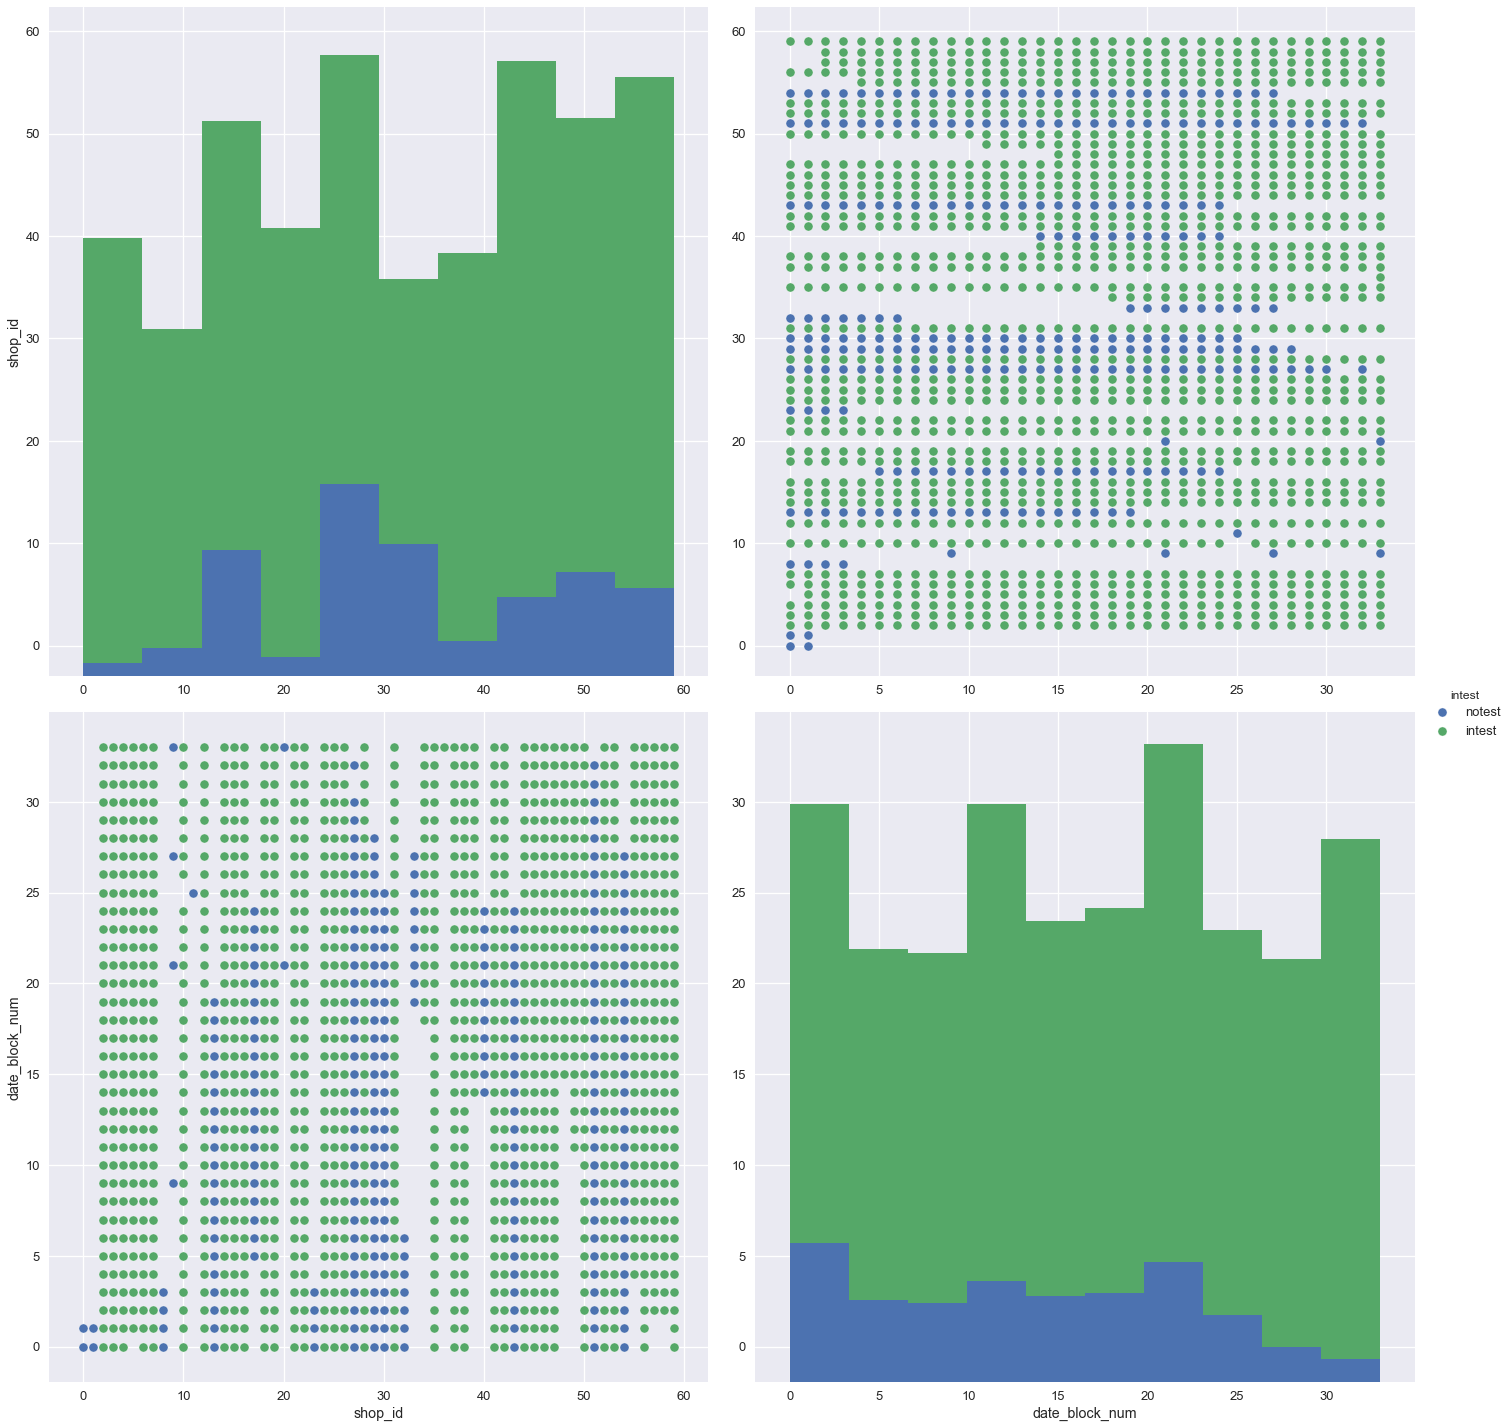

In [29]:
t=(transactions
   .groupby(["shop_id","date_block_num"])
   .item_id.count().reset_index()
 .assign(intest=lambda x: np.where(x.shop_id.isin(test_shop),"intest","notest"))
 [["shop_id","date_block_num","intest"]]

 
)

sns.pairplot(t,hue="intest",size=10)

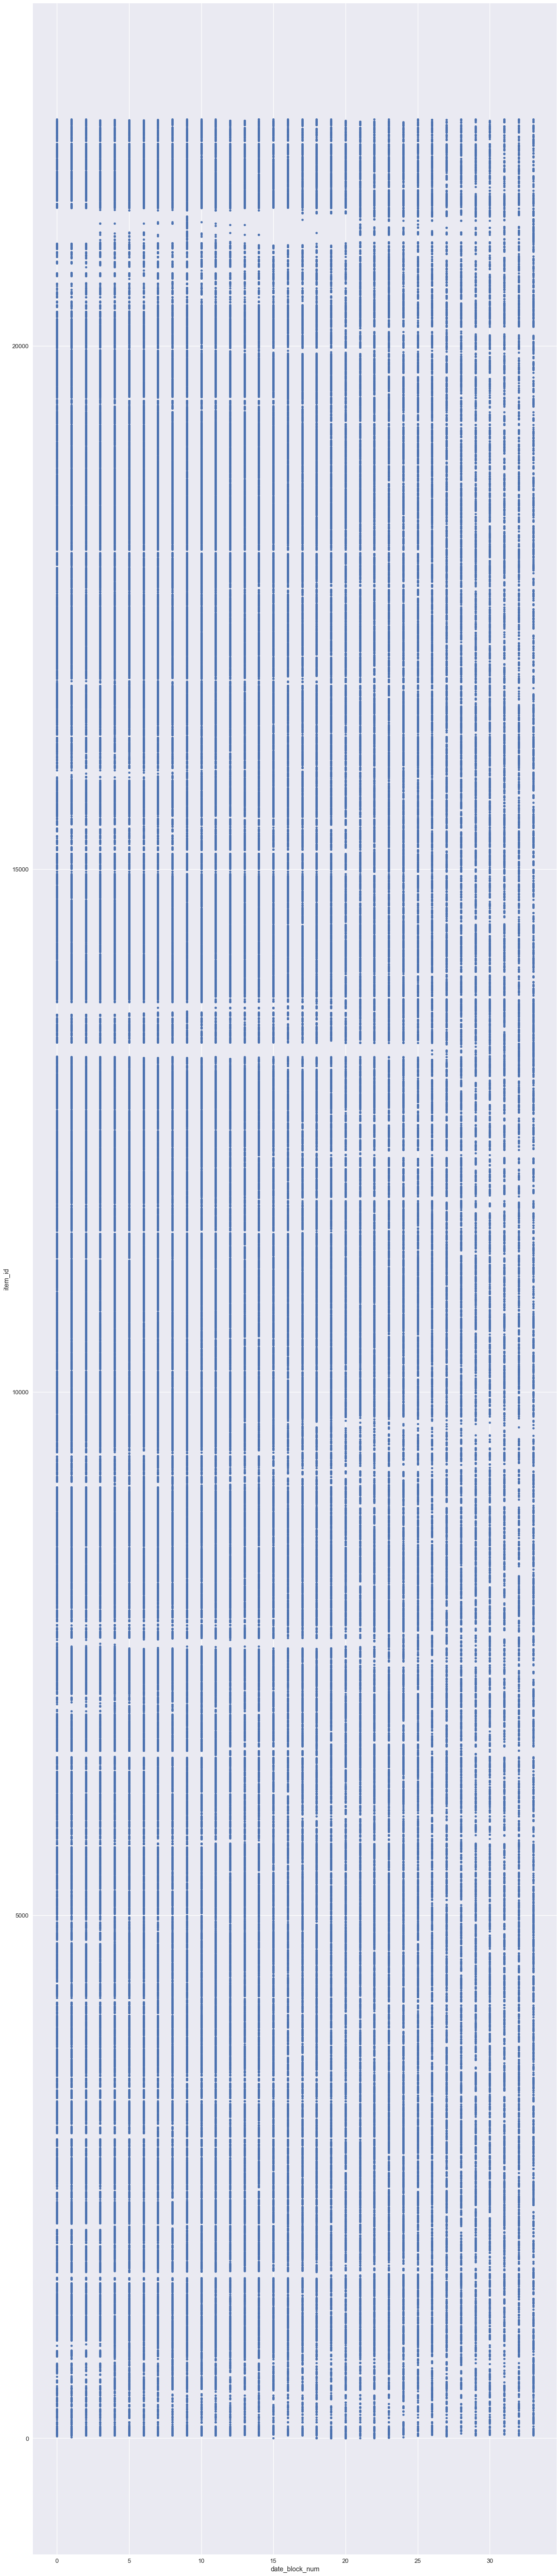

In [64]:
t=(transactions
   .groupby(["item_id","date_block_num"])
   .count().reset_index()
   
 .assign(intest=lambda x: np.where(x.item_id.isin(test_prod) & x.shop_id.isin(test_shop),"intest","notest"))
 [["item_id","date_block_num","intest"]]

 
)
plt.figure(figsize=(20,100))
t.query("intest=='notest'").plot.scatter("date_block_num","item_id",ax=plt.gca())
#t.query("intest=='intest'").plot.scatter("date_block_num","item_id",ax=plt.gca(),c="red",marker="*")
#sns.pairplot(t,hue="intest",size=10)

In [90]:
a=set(transactions.query("date_block_num in [32,33,31,30,29,28,27]").shop_id.sort_values().unique())
np.array(list(a))

array([ 2,  3,  4,  5,  6,  7,  9, 10, 12, 14, 15, 16, 18, 19, 20, 21, 22,
       24, 25, 26, 27, 28, 29, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42, 44,
       45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])

In [82]:
b=set((test.shop_id.sort_values().unique()))
np.array(list(b))

array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
       26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
       50, 52, 53, 55, 56, 57, 58, 59])

In [91]:
a-b

{9, 20, 27, 29, 33, 51, 54}

In [96]:
a=set(transactions.item_id.sort_values().unique())
np.array(list(a))

array([    0,     1,     2, ..., 22167, 22168, 22169])

In [93]:
b=set((test.item_id.sort_values().unique()))
np.array(list(b))

array([ 8192,  8193, 16388, ..., 16374, 16377,  8191])

In [101]:
items.query("item_id==20843")

,item_name,item_id,item_category_id
20843,Фигурка Texas Chainsaw Ultimate Leatherface 17см,20843,72


In [103]:
items.shape

(22170, 3)

In [20]:
regex=r'!|,|[0-9]|"|\?|²|\.|\(|\)|-|\*|/|\#|\+|\:|\[|\]|`|\''
def one(x):
    return [i for i in x if len(i)>=2]
def expander(x):
    for i in x.shop_name:
        x[i]=1

    return x
t=pd.Series((items.item_name
 .str.lower()
 .str.replace(regex,"")
 .str.split()
 .apply(one)
            ))


In [4]:
counts=pd.Series(Counter(chain(*t)))
counts.sort_values(ascending=False).shape

(17816,)

In [8]:
it=(t
   
    
   )
it.iloc[32]=["11"]
it.iloc[1073]=["42"]

In [9]:
counts=pd.Series(Counter(chain(*it)))
counts.sort_values(ascending=False).shape

(17818,)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
vec=CountVectorizer()

In [26]:
t2=t.apply(lambda x: " ".join(x))

In [31]:
X=vec.fit_transform(t2)

In [30]:
features=vec.get_feature_names()

In [77]:
from sklearn.decomposition import TruncatedSVD
pca=TruncatedSVD(n_components=4000)

In [78]:
pca.fit(X)

TruncatedSVD(algorithm='randomized', n_components=4000, n_iter=5,
       random_state=None, tol=0.0)

In [80]:
pca.explained_variance_ratio_.cumsum().max()

0.88727471329457008

In [81]:
res=pca.transform(X)

In [82]:
t2

0                               во власти наваждения пласт
1        abbyy finereader professional edition full pc ...
2                                          лучах славы unv
3                                       голубая волна univ
4                                           коробка стекло
5                          новые американские граффити uni
6                                      удар по воротам uni
7                                      удар по воротам uni
8                                            чай муссолини
9                               шугарлэндский экспресс uni
10                                        за гранью смерти
11                                            линия смерти
12                             михей джуманджи сука любовь
13                                            спасая эмили
14                                чокнутый профессор магия
15                       адреналин один против всех регион
16                                   монгол сбодров реги

In [83]:
t4=pd.DataFrame(res)
t3=pd.concat([t2,t4],axis=1)

In [85]:
t3.iloc[[22165,13197,4967]]

,item_name,0,1,2,3,4,5,6,7,8,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
22165,ядерный титбит pc цифровая версия,1.614,-0.537,-0.012,-0.032,-0.124,-0.037,0.117,0.005,-0.004,...,-0.005,0.001,-0.002,0.002,-0.002,-0.002,-0.000,-0.001,-0.004,0.004
13197,коктейли pc цифровая версия,1.614,-0.537,-0.012,-0.032,-0.124,-0.037,0.117,0.005,-0.004,...,-0.002,-0.000,0.000,-0.001,-0.000,-0.001,-0.000,-0.001,-0.001,-0.000
4967,mysims pc цифровая версия,1.614,-0.537,-0.012,-0.032,-0.124,-0.037,0.117,0.005,-0.004,...,-0.002,-0.000,0.000,-0.001,-0.000,-0.001,-0.000,-0.001,-0.001,-0.000


In [84]:
(t4-t4.iloc[22165]).pipe(lambda x: x**2).sum(axis=1).sort_values()

22165    0.000
13197    0.001
4967     0.001
19353    0.001
8554     0.001
2374     0.001
4224     0.001
7236     0.001
1888     0.001
13082    0.001
8039     0.001
19510    0.001
7645     0.001
4122     0.001
6920     0.001
5846     0.001
3262     0.001
2347     0.001
22080    0.001
3222     0.001
927      0.001
6709     0.001
7871     0.001
2408     0.002
4501     0.036
14976    0.037
20016    0.038
4971     0.039
2069     0.039
495      0.049
         ...  
13116   20.956
13430   21.125
13402   21.439
3095    21.578
13399   21.863
13504   21.941
5576    22.087
5575    22.182
3139    22.188
2861    22.239
3138    22.309
13424   22.465
20551   22.483
4294    22.556
6602    22.642
12709   22.961
6863    23.255
13406   23.411
5460    23.528
20201   23.674
6174    24.576
13494   24.722
5980    24.952
5981    24.952
13499   25.389
1181    25.586
13413   25.823
5598    26.562
5656    30.822
5657    30.830
Length: 22170, dtype: float64